In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Assuming the file is named 'u.data' after upload
data = pd.read_csv('u.data', delimiter='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Display the first few rows of the dataframe
data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
try:
    movies = pd.read_csv('u.item', sep='|', encoding='ISO-8859-1', header=None,names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
except UnicodeDecodeError:
    print("ISO-8859-1 failed, trying latin1 encoding...")
    movies = pd.read_csv('u.item', sep='|', encoding='latin1', header=None,names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])


In [4]:
data = pd.merge(data, movies[['movie_id', 'movie_title']], on='movie_id', how='left')
data.head()

,user_id,movie_id,rating,timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [5]:
data.shape

(100000, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      100000 non-null  int64 
 1   movie_id     100000 non-null  int64 
 2   rating       100000 non-null  int64 
 3   timestamp    100000 non-null  int64 
 4   movie_title  100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data['movie_id'].nunique() # total number of unique movies

1682

In [8]:
data['user_id'].nunique() # total number of unique users

943

In [9]:
data['rating'].unique() # unique ratings

array([3, 1, 2, 4, 5])

In [10]:
# Convert Unix timestamp to datetime
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
# Extract hour of the day, day of the week, and month
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek  # Monday = 0, Sunday = 6
data['month'] = data['datetime'].dt.month

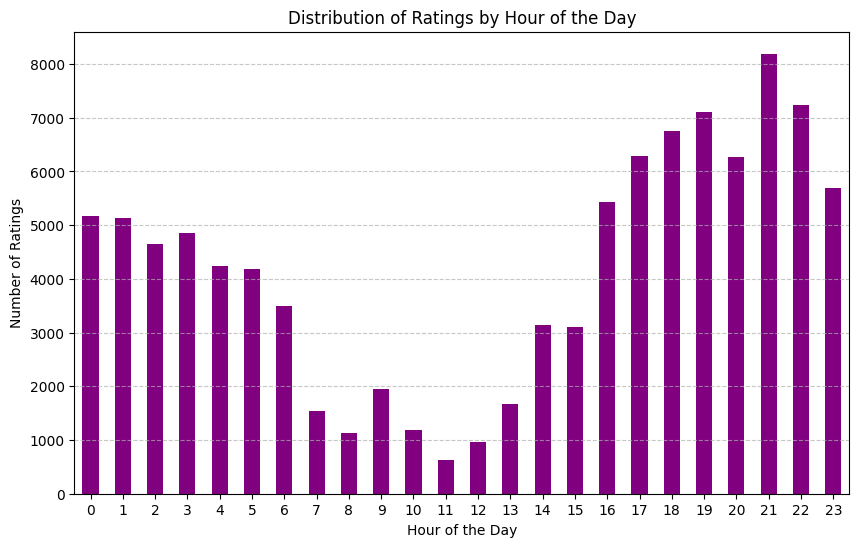

In [11]:
# Plot the distribution of ratings by hour of the day
plt.figure(figsize=(10, 6))
data['hour'].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title('Distribution of Ratings by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Ratings')
plt.xticks(np.arange(0, 24, step=1), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

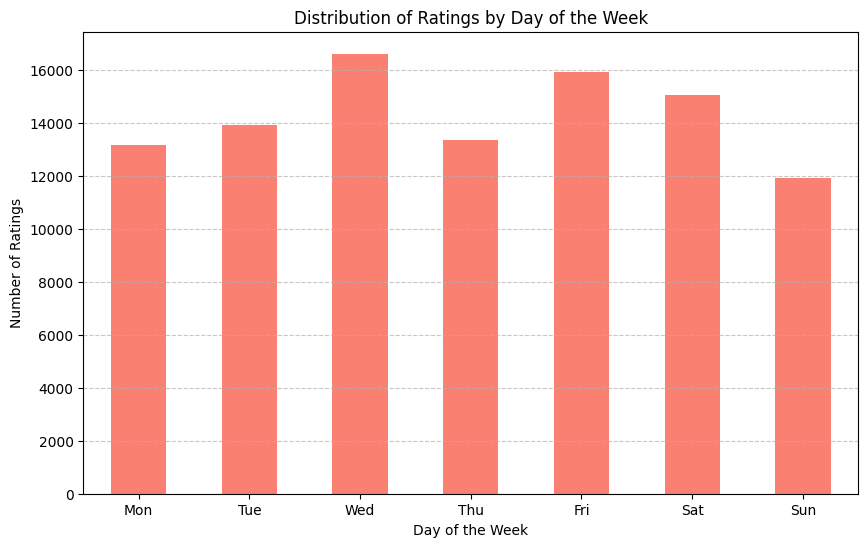

In [12]:
# Plot the distribution of ratings by day of the week
plt.figure(figsize=(10, 6))
data['day_of_week'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Distribution of Ratings by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Ratings')
plt.xticks(np.arange(0, 7, step=1), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
data.isna().sum()

,0
user_id,0
movie_id,0
rating,0
timestamp,0
movie_title,0
datetime,0
hour,0
day_of_week,0
month,0


In [14]:
data.duplicated().sum()

0

In [15]:
data.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'movie_title', 'datetime',
       'hour', 'day_of_week', 'month'],
      dtype='object')

**Collaborative Filtering**

In [16]:
pip install scikit-surprise


RMSE: 0.9341
RMSE: 0.9352
RMSE: 0.9336
RMSE: 0.9305


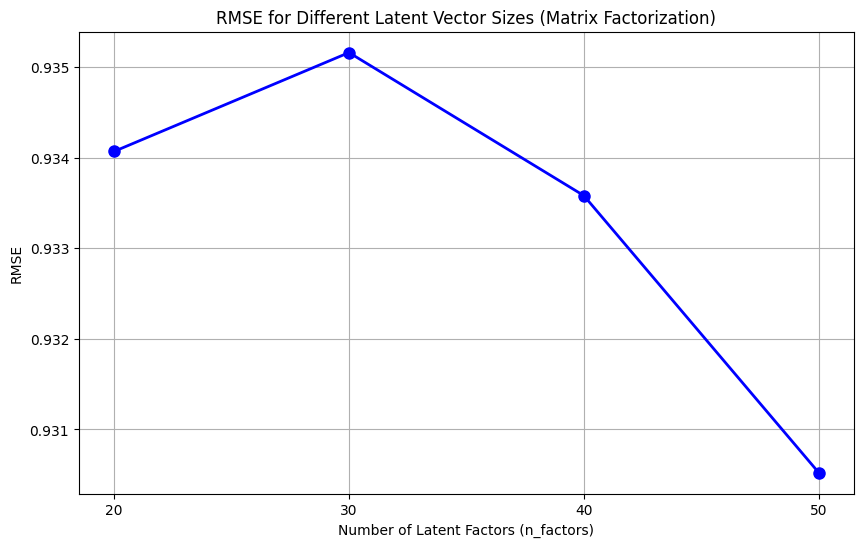

In [17]:
# Prepare data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize list to store RMSE for different n_factors
rmse_values = []
latent_sizes = [20, 30, 40, 50]

# Iterate over different latent vector sizes
for latent_size in latent_sizes:
    model = SVD(n_factors=latent_size)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    rmse_values.append(rmse)

# Plotting RMSE for different latent vector sizes
plt.figure(figsize=(10, 6))
plt.plot(latent_sizes, rmse_values, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title("RMSE for Different Latent Vector Sizes (Matrix Factorization)")
plt.xlabel("Number of Latent Factors (n_factors)")
plt.ylabel("RMSE")
plt.xticks(latent_sizes)
plt.grid(True)
plt.show()

In [66]:
'''def calculate_metrics(predictions, top_k):
    """
    Calculate precision, recall, and F1-score for top-k recommendations.
    predictions: A list of tuples or dicts containing user_id, item_id, true_rating, predicted_rating.
    """
    # Extract predicted ratings (if predictions is a list of dicts)
    if isinstance(predictions[0], dict):  # Check if predictions contain dicts
        predictions = [
            (pred["user_id"], pred["item_id"], pred["true_rating"], pred["est"])
            for pred in predictions
        ]

    # Convert predictions to a NumPy array for further processing
    predictions = np.array(predictions)

    # Reshape user-item matrices
    user_ids = predictions[:, 0].astype(int)
    item_ids = predictions[:, 1].astype(int)
    true_ratings = predictions[:, 2].astype(float)
    pred_ratings = predictions[:, 3].astype(float)

    num_users = user_ids.max() + 1
    num_items = item_ids.max() + 1

    true_matrix = np.zeros((num_users, num_items))
    pred_matrix = np.zeros((num_users, num_items))

    for u, i, t, p in zip(user_ids, item_ids, true_ratings, pred_ratings):
        true_matrix[u, i] = t
        pred_matrix[u, i] = p

    # Get top-k predictions and ground truths
    top_k_preds = np.argsort(-pred_matrix, axis=1)[:, :top_k]
    top_k_true = np.argsort(-true_matrix, axis=1)[:, :top_k]

    # Flatten predictions and ground truths for evaluation
    flat_preds = top_k_preds.flatten()
    flat_true = top_k_true.flatten()

    # Precision, Recall, F1
    precision = precision_score(flat_true, flat_preds, average="micro", zero_division=0)
    recall = recall_score(flat_true, flat_preds, average="micro", zero_division=0)
    f1 = f1_score(flat_true, flat_preds, average="micro", zero_division=0)

    return precision, recall, f1
'''

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(predictions, top_k):
    """
    Calculate precision, recall, and F1-score for top-k recommendations.
    predictions: A list of tuples containing (user_id, item_id, true_rating, predicted_rating).
    """
    # Convert predictions to a NumPy array
    predictions = np.array(predictions)

    # Reshape user-item matrices
    user_ids = predictions[:, 0].astype(int)
    item_ids = predictions[:, 1].astype(int)
    true_ratings = predictions[:, 2].astype(float)
    pred_ratings = predictions[:, 3].astype(float)

    num_users = user_ids.max() + 1
    num_items = item_ids.max() + 1

    true_matrix = np.zeros((num_users, num_items))
    pred_matrix = np.zeros((num_users, num_items))

    for u, i, t, p in zip(user_ids, item_ids, true_ratings, pred_ratings):
        true_matrix[u, i] = t
        pred_matrix[u, i] = p

    precision_list, recall_list, f1_list = [], [], []

    for user in range(num_users):
        # Top-k predictions and ground truth for this user
        user_top_k_preds = np.argsort(-pred_matrix[user])[:top_k]
        user_top_k_true = np.argsort(-true_matrix[user])[:top_k]

        # Convert to binary relevance (1 if relevant, 0 otherwise)
        user_relevant = (true_matrix[user] > 0).astype(int)
        pred_relevant = np.zeros_like(user_relevant)
        pred_relevant[user_top_k_preds] = 1  # Mark top-k items as relevant

        # Precision, Recall, F1
        precision = precision_score(user_relevant, pred_relevant, zero_division=0)
        recall = recall_score(user_relevant, pred_relevant, zero_division=0)
        f1 = f1_score(user_relevant, pred_relevant, zero_division=0)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Average metrics across users
    return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


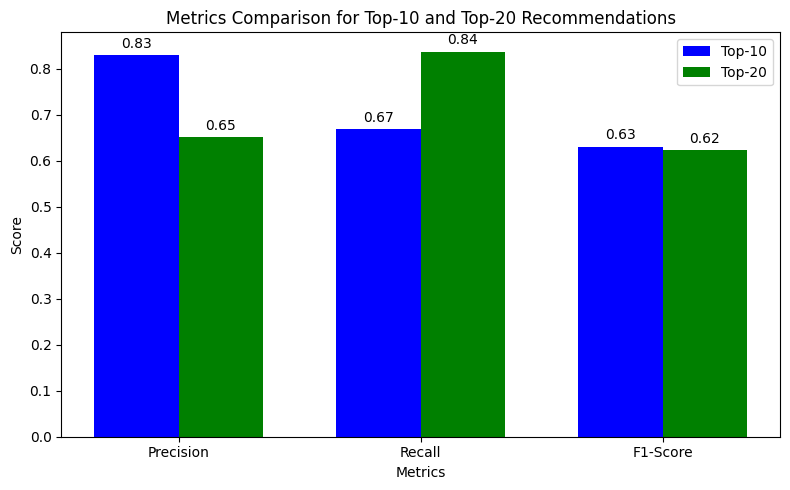

In [69]:
# Metrics for top-10 and top-20
metrics_top_10 = calculate_metrics(predictions, top_k=10)  # Precision, Recall, F1
metrics_top_20 = calculate_metrics(predictions, top_k=20)  # Precision, Recall, F1

# Data preparation
metric_names = ["Precision", "Recall", "F1-Score"]
top_10_values = list(metrics_top_10)
top_20_values = list(metrics_top_20)

# Plot
x = np.arange(len(metric_names))  # Number of metrics
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width / 2, top_10_values, width, label="Top-10", color="blue")
bars2 = ax.bar(x + width / 2, top_20_values, width, label="Top-20", color="green")

# Adding labels, title, and legend
ax.set_ylabel("Score")
ax.set_xlabel("Metrics")
ax.set_title("Metrics Comparison for Top-10 and Top-20 Recommendations")
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Adding data labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',  # Display value
                xy=(bar.get_x() + bar.get_width() / 2, height),  # Position
                xytext=(0, 3),  # Offset
                textcoords="offset points",
                ha="center", va="bottom")

# Show plot
plt.tight_layout()
plt.show()


In [20]:
# Get the user and item latent matrices
#These are both numpy arrays that hold the feature vectors for each user and each item.
user_latent_matrix = model.pu  # User matrix
item_latent_matrix = model.qi  # Item matrix

Matrix Factorization Algorithm
The algorithm seeks to approximate the original user-item matrix
𝑅
R (with missing entries) by factoring it into two smaller matrices:

User Latent Feature Matrix (
𝑃
P):

Rows represent users, and columns represent latent features describing their preferences.
Item Latent Feature Matrix (
𝑄
𝑇
Q
T
 ):

Rows represent items, and columns represent latent features describing item characteristics.
The approximation is given by:

𝑅
≈
𝑃
×
𝑄
𝑇
R≈P×Q
T

Where:

𝑃
∈
𝑅
𝑚
×
𝑘
P∈R
m×k
 : User latent matrix (m = number of users, k = number of latent features).
𝑄
∈
𝑅
𝑛
×
𝑘
Q∈R
n×k
 : Item latent matrix (n = number of items, k = number of latent features).


In [24]:
def get_top_n_for_user(predictions, user_id, n=10):

    # Filter predictions for the given user ID
    user_predictions = [(iid, est) for uid, iid, true_r, est, _ in predictions if uid == user_id]

    # Sort the predictions by the estimated rating in descending order
    user_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top-N predictions for the user
    return user_predictions[:n]

# Input user ID and number of recommendations (n)
try:
    user_id = int(input("Enter User ID: "))
    n = int(input("Enter the number of recommendations (N): "))

    # Get predictions for the specific user
    top_recommendations = get_top_n_for_user(predictions, user_id, n)

    # Print the recommendations
    print(f"\nTop {n} Recommended Items for User {user_id}:")
    for idx, (movie_id, predicted_rating) in enumerate(top_recommendations, 1):
        movie_name = movies.loc[movies['movie_id'] == movie_id, 'movie_title'].values[0]

        print(f"{idx}. Movie ID: {movie_id},Movie Name: {movie_name}, Predicted Rating: {predicted_rating:.2f}")
except ValueError:
    print("Invalid input. Please enter valid integers for User ID and N.")


Enter User ID: 5
Enter the number of recommendations (N): 5

Top 5 Recommended Items for User 5:
1. Movie ID: 172,Movie Name: Empire Strikes Back, The (1980), Predicted Rating: 3.97
2. Movie ID: 181,Movie Name: Return of the Jedi (1983), Predicted Rating: 3.82
3. Movie ID: 144,Movie Name: Die Hard (1988), Predicted Rating: 3.80
4. Movie ID: 135,Movie Name: 2001: A Space Odyssey (1968), Predicted Rating: 3.59
5. Movie ID: 210,Movie Name: Indiana Jones and the Last Crusade (1989), Predicted Rating: 3.53


**Sentiment Analysis**

In [26]:
data = pd.read_csv('u.data', delimiter='\t', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [27]:
df= pd.merge(movies, data, on='movie_id')

In [28]:
df['movie_title'].nunique()

1664

In [29]:
df.shape

(100000, 27)

In [30]:
df.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,66,3,883601324


In [31]:
df.to_csv('df.csv') #movies and item merged

Sentiment Analysis using Reddit Post

> Add blockquote



In [32]:
df_reviews=pd.read_csv('reviews.csv') #reviews scraped from reddit of each movies

In [70]:
df_reviews.columns

Index(['movie_id', 'movie_title', 'review', 'preprocessed_description',
       'polarity'],
      dtype='object')

In [33]:
df_reviews['movie_id'].nunique()

1682

In [34]:
df_reviews.isna().sum()

,0
movie_id,0
movie_title,0
review,151


In [35]:
df_reviews.sample(5)

,movie_id,movie_title,review
4455,1007,Waiting for Guffman (1996),My Updated Movie Review ListEvery so often I p...
4714,1067,Bottle Rocket (1996),Bottle Rocket (1996)
2404,523,Cool Hand Luke (1967),"Using the average scores from IMDb, Rotten Tom..."
6300,1511,Children of the Revolution (1996),In the last 2 years I've watched 300 movies. H...
1746,380,Star Trek: Generations (1994),What makes did you see in theaters as a kid?Fo...


In [36]:
df_reviews.shape

(6846, 3)

**Data Preprocessing**

In [37]:
pip install nltk

In [38]:
import nltk
import re
import string
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [39]:
#initialize sentiment analyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):

    sentences = nltk.sent_tokenize(text)
    compound_scores = []

    for sentence in sentences:
        sentiment = analyzer.polarity_scores(sentence)
        compound_scores.append(sentiment['compound'])

    if compound_scores:
        avg_compound_score = np.mean(compound_scores)
    else:
        avg_compound_score = 0

    return avg_compound_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**Preprocess text **

In [40]:
def remove_urls(desc):
    return re.sub(r'(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?\/[a-zA-Z0-9]{2,}|((https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?)|(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})?', ' ', desc)

In [41]:
def remove_non_chrs(text):
    return text.replace('\xa0', ' ') #to remove anything followed by /+

In [42]:
# replace multiple white sapaces with a signle space
def remove_multiple_spaces(desc):
    return re.sub(r'\s+', ' ', desc)

In [43]:
# fuction to convert into lowercase
def convert_to_lowercase(text):
    return text.lower()

In [44]:
# remove non english characters using regex
def remove_non_eng_chrs(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [45]:
def punctuation_removal(text):
    sp = string.punctuation
    sp.join('“”’')
    for p in sp:
        text = text.replace(p, "")
    return text

In [46]:
def tokenization(text):
    tokens = nltk.word_tokenize(text)
    return tokens


In [47]:
# function to fix spell
def spell_len_fix(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [48]:
# fucntion to preprocess data
def text_preprocess_pipeline(desc):
    if not isinstance(desc, str):
        print(desc)
        return []

    text = remove_urls(desc)

    text = remove_non_chrs(desc)
    text = remove_multiple_spaces(desc)
    text = convert_to_lowercase(desc)
    text = remove_non_eng_chrs(desc)
    text = spell_len_fix(text)
    text = punctuation_removal(text)


    return(text)

In [ ]:
# preprocess text, using tqdm for displaying progress bar
tqdm.pandas(desc="Pre-Processing Description")
df_reviews['preprocessed_description'] = df_reviews.review.progress_apply(text_preprocess_pipeline)

In [50]:
#analyze_sentiment expects a string input, hence converting preprocessed_description to string
df_reviews['preprocessed_description'] = df_reviews['preprocessed_description'].astype(str)


In [51]:
df_reviews['movie_id'].nunique()

1682

In [52]:
tqdm.pandas(desc="Analyze Sentiment")
#df_reviews['polarity']= df_reviews['review'].progress_apply(analyze_sentiment)
df_reviews['polarity']= df_reviews['preprocessed_description'].apply(analyze_sentiment)

In [53]:
df_reviews.isna().sum()

,0
movie_id,0
movie_title,0
review,151
preprocessed_description,0
polarity,0


In [71]:
df_reviews.describe()

,movie_id,polarity
count,6846.000000,6846.000000
mean,784.194128,0.214053
std,475.588452,0.857476
min,1.000000,-0.999900
25%,372.000000,-0.917600
50%,755.000000,0.748600
75%,1176.750000,0.996700
max,1682.000000,1.000000


In [54]:
average_polarity = df_reviews.groupby('movie_id')['polarity'].mean().reset_index()
average_polarity.rename(columns={'polarity': 'sentiment_score'}, inplace=True)

In [55]:
average_polarity.shape

(1682, 2)

In [56]:
def sentiments_classification(compound_score):
    if compound_score >= 0.05:
        sentiment = 'pos'
    elif compound_score<=-0.05:
        sentiment = 'neg'
    else:
        sentiment = 'neu'
    return sentiment

In [57]:
average_polarity['Sentiments']=average_polarity['sentiment_score'].apply(sentiments_classification)

In [58]:
average_polarity.head()

,movie_id,sentiment_score,Sentiments
0,1,0.24264,pos
1,2,-0.67438,neg
2,3,-0.20806,neg
3,4,-0.23356,neg
4,5,-0.52534,neg


In [59]:
average_polarity.shape

(1682, 3)

In [60]:
average_polarity.to_csv('average_polarity.csv')

(array([0, 1, 2]), [Text(0, 0, 'pos'), Text(1, 0, 'neg'), Text(2, 0, 'neu')])

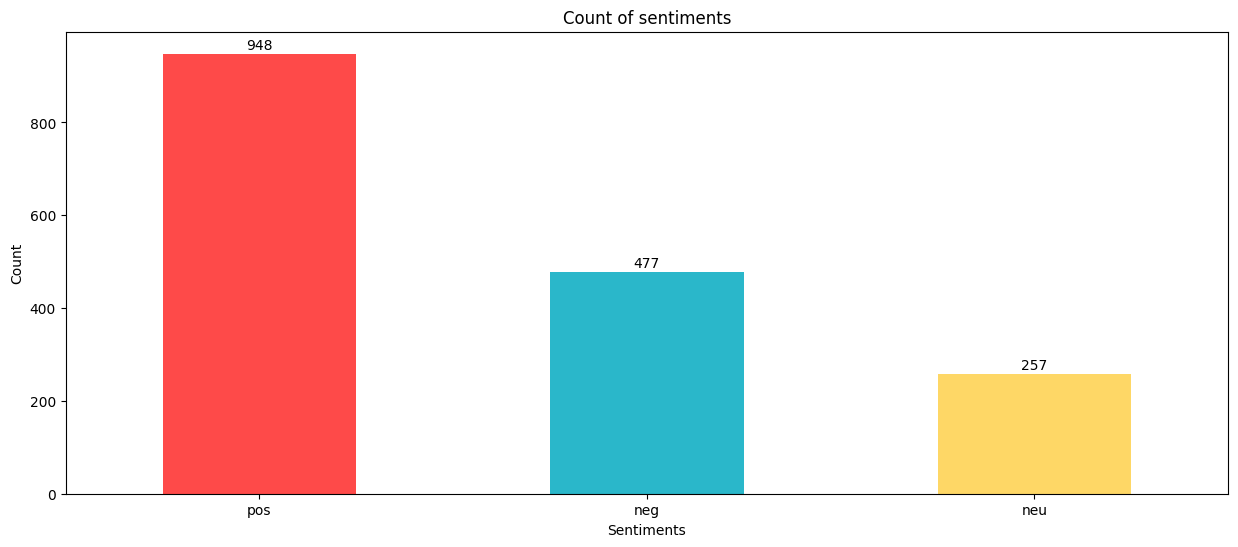

In [61]:
palette4 = ['#FE4A49','#2AB7CA','#FED766','#03CEA4']
x = average_polarity['Sentiments'].value_counts().plot(kind='bar', title = 'Count of sentiments',xlabel = 'Sentiments', ylabel = 'Count',color= palette4, figsize = (15,6))
for bar in x.patches:
    plt.annotate(str(bar.get_height()), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
             xytext=(0, 1.25),
             textcoords="offset points",
             ha='center', va='bottom')
plt.xticks(rotation=0)


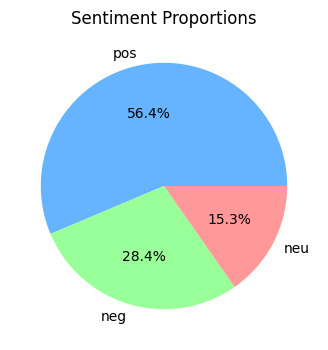

In [62]:
def plot_sentiment_pie(data):
    sentiment_counts = data['Sentiments'].value_counts()

    plt.figure(figsize=(4, 4))
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
    plt.title('Sentiment Proportions')
    plt.show()

plot_sentiment_pie(average_polarity)

In [63]:
df_reviews.to_csv('df_reviews_sentiments.csv')

citation
1. https://www.kaggle.com/code/arushikhokharr/a-beginner-s-guide-to-recommendation-systems